#### Importing Required Libraries

In [1]:
# For reproducibility with CuBLAS
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

In [2]:
import re
import random
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, multilabel_confusion_matrix

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
os.getcwd()

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
EE782   = '/content/drive/MyDrive/EE782'
os.makedirs(EE782,exist_ok= True)

In [6]:
def set_seed(seed):

    # Numpy/Python RNGs
    random.seed(seed)
    np.random.seed(seed)

    # CPU/GPU RNGs
    torch.manual_seed(seed)  # RNG for CPU tensors
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # RNG for all GPU tensors

    # cuDNN determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

In [7]:
SEED = 999   # 123, 999, etc.
set_seed(SEED)
print(f"Seed set to {SEED}")

Seed set to 999


#### CheXpert-v1.0-small(Kaggle)

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ashery/chexpert/versions/1


#### EDA of CheXpert-v1.0-small dataset

In [ ]:
!ls  /root/.cache/kagglehub/datasets/ashery/chexpert/versions/1

train  train.csv  valid  valid.csv


In [ ]:
!ls /root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train

Streaming output truncated to the last 5000 lines.
patient07909  patient20817  patient33725  patient46633	patient59541
patient07910  patient20818  patient33726  patient46634	patient59542
patient07911  patient20819  patient33727  patient46635	patient59543
patient07912  patient20820  patient33728  patient46636	patient59544
patient07913  patient20821  patient33729  patient46637	patient59545
patient07914  patient20822  patient33730  patient46638	patient59546
patient07915  patient20823  patient33731  patient46639	patient59547
patient07916  patient20824  patient33732  patient46640	patient59548
patient07917  patient20825  patient33733  patient46641	patient59549
patient07918  patient20826  patient33734  patient46642	patient59550
patient07919  patient20827  patient33735  patient46643	patient59551
patient07920  patient20828  patient33736  patient46644	patient59552
patient07921  patient20829  patient33737  patient46645	patient59553
patient07922  patient20830  patient33738  patient46646	patient595

In [ ]:
!ls /root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train/patient00001

study1


In [ ]:
!ls /root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train/patient00001/study1

view1_frontal.jpg


In [ ]:

img_pth = '/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train/patient00001/study1/view1_frontal.jpg'
img = cv2.imread(img_pth)
print(img.shape)

(320, 389, 3)


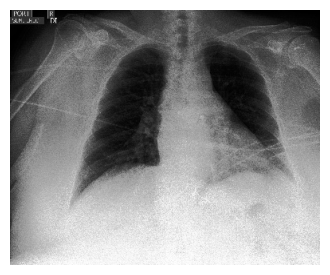

In [ ]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

#### Chexpert Data

In [ ]:
DATA_DIR  = '/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1'
TRAIN_DIR = os.path.join(DATA_DIR,'train')
VALID_DIR = os.path.join(DATA_DIR,'valid')
TRAIN_CSV = os.path.join(DATA_DIR,'train.csv')
VALID_CSV = os.path.join(DATA_DIR,'valid.csv')

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
print(train_df.shape)
train_df.head()

(223414, 19)


Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN          NaN    NaN            NaN        NaN          NaN   
1           1.0          NaN   -1.0           -1.0        NaN         -1.0   
2           1.0          NaN    NaN           -1.0        NaN          NaN   
3           1.0          NaN    NaN           -1.0        NaN          NaN   
4           NaN          NaN    1.0            NaN        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               NaN            NaN       NaN              1.0  
1           NaN              -1.0            NaN       1.0              NaN  
2           NaN               NaN            NaN       1.0              NaN  
3           NaN               NaN            NaN       1.0              NaN  
4           0.0               NaN            NaN       NaN              NaN

In [ ]:
val_df = pd.read_csv(VALID_CSV)
print(val_df.shape)
val_df.head()

(234, 19)


Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
2  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
2         Lateral   NaN         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
2           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
2           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0

#### Selecting Only Frontal Images (ignoring lateral images)

In [ ]:
train_df = train_df[train_df['Frontal/Lateral'] == 'Frontal']
print("After filtering frontal images:", len(train_df))

After filtering frontal images: 191027


In [ ]:
train_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   
5  CheXpert-v1.0-small/train/patient00004/study1/...  Female   20   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   
5         Frontal    PA         1.0                         0.0           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN          NaN    NaN            NaN        NaN          NaN   
1           1.0          NaN   -1.0           -1.0        NaN         -1.0   
2           1.0          NaN    NaN           -1.0        NaN          NaN   
4           NaN          NaN    1.0            NaN        NaN          NaN   
5           NaN          NaN    NaN            0.0        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               NaN            NaN       NaN              1.0  
1           NaN              -1.0            NaN       1.0              NaN  
2           NaN               NaN            NaN       1.0              NaN  
4           0.0               NaN            NaN       NaN              NaN  
5           NaN               0.0            NaN       NaN              NaN

In [ ]:
val_df = val_df[val_df['Frontal/Lateral'] == 'Frontal']
print("After filtering frontal images:", len(val_df))

After filtering frontal images: 202


In [ ]:
val_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   
5  CheXpert-v1.0-small/valid/patient64545/study1/...  Female   55   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   
5         Frontal    AP         0.0                         1.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   
5           1.0          0.0    0.0            0.0        0.0          1.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0  
5           0.0               1.0            0.0       0.0              0.0

#### Labels

In [8]:
# canonical labels
canonical = [
    "No Finding",
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Pleural Effusion",
    "Pneumonia",
    "Pneumothorax"]

In [9]:
# mapping for CheXpert CSV columns -> CANONICAL
chexpert_to_canon = {
    "No Finding": "No Finding",
    "Atelectasis": "Atelectasis",
    "Cardiomegaly": "Cardiomegaly",
    "Lung Opacity": "Consolidation",    # unifying CheXpert "Lung Opacity" -> "Consolidation"
    "Edema": "Edema",
    "Pleural Effusion": "Pleural Effusion",
    "Pneumonia": "Pneumonia",
    "Pneumothorax": "Pneumothorax",
    "Consolidation": "Consolidation",
}

In [10]:
# mapping for NIH ChestX-ray14 -> CANONICAL
nih_to_canon = {
    "No Finding": "No Finding",
    "Atelectasis": "Atelectasis",
    "Cardiomegaly": "Cardiomegaly",
    "Consolidation": "Consolidation",
    "Edema": "Edema",
    "Effusion": "Pleural Effusion",   # mapping NIH "Effusion" -> "Pleural Effusion"
    "Pneumonia": "Pneumonia",
    "Pneumothorax": "Pneumothorax",
    # NIH has many other columns (Mass, Nodule, Infiltration, etc.)
    # these are ignored or mapped to None (not used)
}

In [11]:
def make_canonical_df(df_raw: pd.DataFrame, mapping: dict, canonical: list, path_col="Path"):
    out = pd.DataFrame()
    out["Path"] = df_raw[path_col].values

    for c in canonical:
        out[c] = 0.0
        out[c + "_mask"] = 0

    # group source columns that map to the same canonical target
    from collections import defaultdict
    grouped = defaultdict(list)
    for src_col, canon_col in mapping.items():
        grouped[canon_col].append(src_col)

    for canon_col, src_cols in grouped.items():
        for src_col in src_cols:
            if src_col not in df_raw.columns:
                continue
            vals = df_raw[src_col].values
            for i, v in enumerate(vals):
                if pd.isna(v) or float(v) == -1.0:
                    continue
                vv = float(v)
                # logical OR — if any mapped column has a positive finding, mark as positive
                if vv == 1.0:
                    out.at[i, canon_col] = 1.0
                # mark mask as valid if *any* mapped column has a valid value
                out.at[i, canon_col + "_mask"] = 1

    return out

#### Canonical DataFrames

In [ ]:
train_df_canon = make_canonical_df(train_df, chexpert_to_canon,canonical,"Path")

In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  0  
2           0.0                  0  
3           0.0                  1  
4           0.0                  0

In [ ]:
val_df_canon = make_canonical_df(val_df, chexpert_to_canon,canonical,"Path")

In [ ]:
val_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...         0.0   
1  CheXpert-v1.0-small/valid/patient64542/study1/...         0.0   
2  CheXpert-v1.0-small/valid/patient64543/study1/...         0.0   
3  CheXpert-v1.0-small/valid/patient64544/study1/...         1.0   
4  CheXpert-v1.0-small/valid/patient64545/study1/...         0.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 1           1.0   
1                1          0.0                 1           0.0   
2                1          0.0                 1           0.0   
3                1          0.0                 1           0.0   
4                1          1.0                 1           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  1            1.0                   1    0.0           1   
1                  1            0.0                   1    0.0           1   
2                  1            1.0                   1    1.0           1   
3                  1            0.0                   1    0.0           1   
4                  1            1.0                   1    0.0           1   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      1        0.0               1   
1               0.0                      1        0.0               1   
2               0.0                      1        0.0               1   
3               0.0                      1        0.0               1   
4               1.0                      1        0.0               1   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  1  
2           0.0                  1  
3           0.0                  1  
4           0.0                  1

#### Patient wise splitting the data to prevent data leakage

In [ ]:
def extract_patient_id(path: str) -> str:
    """Extract patient identifier like 'patient00001' from a file path."""
    match = re.search(r"(patient\d+)", path)
    return match.group(1) if match else None

In [ ]:
train_df_canon["PatientID"] = train_df_canon["Path"].apply(extract_patient_id)

In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask     PatientID  
0           0.0                  1  patient00001  
1           0.0                  0  patient00002  
2           0.0                  0  patient00002  
3           0.0                  1  patient00003  
4           0.0                  0  patient00004

* The "train" split of the dataset is split into (train + val) data
* The "valid" split of the dataset is considered as test data for evaluation

In [ ]:
# unique patient IDs
unique_patients = train_df_canon["PatientID"].unique()

train_patients, val_patients = train_test_split(
    unique_patients,
    test_size=0.15,      # 15% for validation
    random_state=SEED,
    shuffle=True
)

# assign split labels
train_df_canon["split"] = train_df_canon["PatientID"].apply(
    lambda x: "val" if x in val_patients else "train")

print(train_df_canon["split"].value_counts())

split
train    162309
val       28718
Name: count, dtype: int64


In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask     PatientID  split  
0           0.0                  1  patient00001  train  
1           0.0                  0  patient00002  train  
2           0.0                  0  patient00002  train  
3           0.0                  1  patient00003  train  
4           0.0                  0  patient00004  train

In [ ]:
train_data = train_df_canon[train_df_canon["split"] == "train"].reset_index(drop=True)
val_data   = train_df_canon[train_df_canon["split"] == "val"].reset_index(drop=True)
test_data  = val_df_canon

print(f"""Length of each split:
      Train: {len(train_data)}
      Val  : {len(val_data)}
      Test : {len(test_data)}""")

Length of each split:
      Train: 162309
      Val  : 28718
      Test : 202


In [ ]:
train_data_small = train_data.sample(frac=0.1, random_state=SEED).reset_index(drop=True)
val_data_small   = val_data.sample(frac=0.1, random_state=SEED).reset_index(drop=True)

#### Data Transforms

In [12]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),     # RandomHorizontalFlip() uses torch.rand under the hood, global seed ensures reproducibilty
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # gray→RGB
    transforms.Normalize(mean= imagenet_mean,   # IMAGENET statistics
                         std = imagenet_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
   transforms.Normalize(mean= imagenet_mean,   # IMAGENET statistics
                        std = imagenet_std)
])

#### Custom Dataset Class

In [ ]:
class CheXpertDataset(Dataset):
    def __init__(self, df, transform=None, target_cols=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_cols = target_cols
        self.mask_cols = [c + "_mask" for c in target_cols]
        self.classes = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["Path"]
        correct_img_path = img_path.replace("CheXpert-v1.0-small",DATA_DIR)
        image = Image.open(correct_img_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row[self.target_cols].to_numpy(dtype=np.float32))
        mask = torch.tensor(row[self.mask_cols].to_numpy(dtype=np.float32))
        return image, label, mask

#### DataLoaders

In [ ]:
# Seed function for DataLoader workers
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
target_cols = canonical
train_dataset = CheXpertDataset(train_data_small,   train_transforms, target_cols)
val_dataset   = CheXpertDataset(val_data_small ,    val_transforms ,  target_cols)
chexpert_test_dataset  = CheXpertDataset(test_data, val_transforms ,  target_cols)

In [ ]:
# Generator for DataLoader
g = torch.Generator()
g.manual_seed(SEED)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

chexpert_test_loader = DataLoader(
    chexpert_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [ ]:
img, label, mask = train_dataset[0]
print(type(img), img.shape)
print(type(label), label)

<class 'torch.Tensor'> torch.Size([3, 224, 224])
<class 'torch.Tensor'> tensor([1., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
images, labels, mask = next(iter(train_loader))
print(images.shape)   # [BATCH_SIZE, 3, 224, 224]
print(labels.shape)   # [BATCH_SIZE,num_classes]
print(mask.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 8])
torch.Size([32, 8])


#### Classfication Models

In [13]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

def build_resnet50(num_classes, pretrained=True):
  model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.fc.in_features
  model.fc = nn.Linear(in_features, num_classes)
  return model

def build_densenet121(num_classes, pretrained=True):
  model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.classifier.in_features
  model.classifier = nn.Sequential(
      nn.Dropout(0.3),
      nn.Linear(in_features, num_classes))
  return model

def build_vit_b_16(num_classes, pretrained=True):
  model = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.heads.head.in_features
  model.heads.head = nn.Linear(in_features, num_classes)
  return model

def build_convnext(num_classes, pretrained=True):
  model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
  model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
  return model

### Training

##### Helper Functions

In [14]:
num_classes = len(canonical)
num_classes

8

In [15]:
def masked_bce_loss(outputs, targets, masks, criterion):
    """
    Compute BCE loss while ignoring masked labels.

    outputs: (B, C) raw logits
    targets: (B, C) 0/1
    masks:   (B, C) 1=valid, 0=ignore
    """
    loss = criterion(outputs, targets)  # per-element
    loss = loss * masks                 # zero-out ignored labels
    valid = masks.sum()
    if valid == 0:
        return torch.tensor(0.0, device=outputs.device)
    return loss.sum() / valid

In [16]:
def train(CHECKPOINT_DIR, model, train_loader, val_loader, criterion, optimizer, scheduler,
          num_epochs, resume_epoch=None, patience=5):
    start_epoch = 1
    best_val_acc = 0.0
    epochs_no_improve = 0

    metrics = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    # Resume training if requested
    if resume_epoch is not None:
        resume_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{resume_epoch-1}.pth")
        if os.path.exists(resume_path):
            checkpoint = torch.load(resume_path, map_location=device)
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            best_val_acc = checkpoint.get("best_val_acc", 0.0)
            start_epoch = resume_epoch
            print(f"Resuming from epoch {start_epoch} with best val acc {best_val_acc:.4f}")
        else:
            print(f"Checkpoint not found at {resume_path}, starting fresh.")

    for epoch in range(start_epoch, num_epochs + 1):
        print(f"----------------- Epoch {epoch} -----------------")

        # ---------- TRAIN ----------
        model.train()
        train_loss_total = 0.0
        train_corrects_total = 0.0
        total_train_labels = 0.0

        for images, labels, masks in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = masked_bce_loss(outputs, labels, masks, criterion)
            loss.backward()
            optimizer.step()

            train_loss_total += loss.item() * masks.sum().item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_corrects_total += ((preds == labels) * masks).sum().item()
            total_train_labels += masks.sum().item()

        epoch_train_loss = train_loss_total / total_train_labels
        epoch_train_acc = train_corrects_total / total_train_labels

        metrics["train_loss"].append(epoch_train_loss)
        metrics["train_acc"].append(epoch_train_acc)
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f}\n")

        # ---------- VALIDATION ----------
        model.eval()
        val_loss_total = 0.0
        val_corrects_total = 0.0
        total_val_labels = 0.0

        with torch.no_grad():
            for images, labels, masks in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
                images, labels, masks = images.to(device), labels.to(device), masks.to(device)
                outputs = model(images)
                loss = masked_bce_loss(outputs, labels, masks, criterion)
                val_loss_total += loss.item() * masks.sum().item()

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                val_corrects_total += ((preds == labels) * masks).sum().item()
                total_val_labels += masks.sum().item()

        epoch_val_loss = val_loss_total / total_val_labels
        epoch_val_acc = val_corrects_total / total_val_labels

        metrics["val_loss"].append(epoch_val_loss)
        metrics["val_acc"].append(epoch_val_acc)
        print(f"Validation Loss: {epoch_val_loss:.4f} | Validation Accuracy: {epoch_val_acc:.4f}\n")

        # ---------- CHECKPOINTING ----------
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch
            epochs_no_improve = 0

            best_ckpt_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
            torch.save({
                "best_epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": epoch_val_loss,
                "best_val_acc": best_val_acc,
                "metrics": metrics,
            }, best_ckpt_path)
            print(f"New best model saved at epoch {best_epoch} with val accuracy = {best_val_acc:.4f}\n")
        else:
            epochs_no_improve += 1

        # Save checkpoint for current epoch
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "best_epoch": best_epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": epoch_val_loss,
            "best_val_acc": best_val_acc,
            "metrics": metrics,
        }, checkpoint_path)

        # ---------- EARLY STOPPING ----------
        if epochs_no_improve >= patience and epoch != num_epochs:
            print(f"\nEarly stopping. No improvement in {patience} epochs")
            break

        scheduler.step()

    print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
    return metrics

In [17]:
def plot_train_val_acc(metrics):
  epochs = range(1, len(metrics['train_acc']) + 1)
  plt.figure(figsize=(5,3))
  plt.plot(epochs, metrics['train_acc'], label='Train Acc')
  plt.plot(epochs, metrics['val_acc'], label='Val Acc')
  plt.legend()
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.xticks(epochs)
  plt.show()

In [18]:
def evaluate_model(model, test_loader, device, classes, threshold=0.5):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for images, labels, masks in test_loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            # Apply mask
            labels = labels * masks
            probs  = probs * masks
            preds  = preds * masks

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()

    print("------ Per-Class Metrics ------ ")
    per_class_auc, per_class_ap = [], []

    for i, cls in enumerate(classes):
        valid_idx = ~np.isnan(all_labels[:, i])
        if valid_idx.sum() == 0:
            continue
        try:
            auc = roc_auc_score(all_labels[valid_idx, i], all_probs[valid_idx, i])
        except ValueError:
            auc = np.nan
        ap = average_precision_score(all_labels[valid_idx, i], all_probs[valid_idx, i])
        per_class_auc.append(auc)
        per_class_ap.append(ap)
        print(f"{cls:20s} | AUC: {auc:.3f} | AP: {ap:.3f}")

    mean_auc = np.nanmean(per_class_auc)
    mean_ap = np.nanmean(per_class_ap)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')

    print("\n------ Summary ------ ")
    print(f"Mean AUC: {mean_auc:.3f}")
    print(f"Mean AP:  {mean_ap:.3f}")
    print(f"Macro F1: {macro_f1:.3f}")
    print(f"Micro F1: {micro_f1:.3f}")

In [19]:
def visualize_predictions(model, test_loader, device, classes, num_images=12, fontsize=8):
    model.eval()
    plt.figure(figsize=(12, 6))
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std  = [0.229, 0.224, 0.225]

    all_images, all_labels = [], []

    # Collect a subset of images & labels
    with torch.no_grad():
        for images, labels, masks in test_loader:
            all_images.append(images)
            all_labels.append(labels)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Pick random samples
    random_indices = random.sample(range(len(all_labels)), num_images)

    for i, idx in enumerate(random_indices):
        img = all_images[idx].to(device)
        label = all_labels[idx].to(device)

        outputs = model(img.unsqueeze(0))
        probs = torch.sigmoid(outputs)
        pred = (probs > 0.5).squeeze(0).cpu().numpy()
        true = label.cpu().numpy()

        true_labels = [classes[j] for j, v in enumerate(true) if v == 1]
        pred_labels = [classes[j] for j, v in enumerate(pred) if v == 1]

        # Unnormalize image
        img = img.cpu() * torch.tensor(imagenet_std)[:, None, None] + torch.tensor(imagenet_mean)[:, None, None]
        img = img.permute(1, 2, 0).numpy().clip(0, 1)

        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

        # Create wrapped label strings for clarity
        true_text = "T: " + ", ".join(true_labels) if true_labels else "T: None"
        pred_text = "P: " + ", ".join(pred_labels) if pred_labels else "P: None"
        wrapped_text = "\n".join(textwrap.wrap(true_text + " | " + pred_text, width=40))

        plt.text(0.5, -0.1, wrapped_text, fontsize=fontsize, ha='center', va='top', wrap=True, transform=plt.gca().transAxes)

    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)  # adds spacing between rows
    plt.show()

#### ResNet50

In [ ]:
resnet50_CHECKPOINT_DIR = os.path.join(EE782, f'resnet50_checkpoints_seed_{SEED}')
os.makedirs(resnet50_CHECKPOINT_DIR, exist_ok = True)
resnet50_CHECKPOINT_DIR

'/content/drive/MyDrive/EE782/resnet50_checkpoints_seed_999'

In [34]:
def test_acc_best_model_resnet50(CHECKPOINT_DIR, num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model      = build_resnet50(num_classes, False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_label_acc = test_corrects.double() / total_test_labels
  return test_label_acc, best_model

In [ ]:
def test_acc_ckpt_resnet50(CHECKPOINT_DIR,num_classes,test_loader,ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_resnet50(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds == labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels

  return test_acc, model

In [ ]:
resnet50_model    = build_resnet50(num_classes)
resnet50_model    = resnet50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 99.7MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(resnet50_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train( resnet50_CHECKPOINT_DIR, resnet50_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 508/508 [03:06<00:00,  2.73it/s]


Train Loss: 0.3422 | Train Accuracy: 0.8490



Val Epoch 1: 100%|██████████| 90/90 [00:26<00:00,  3.36it/s]


Validation Loss: 0.3015 | Validation Accuracy: 0.8798

New best model saved at epoch 1 with val accuracy = 0.8798

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 508/508 [03:00<00:00,  2.81it/s]


Train Loss: 0.2980 | Train Accuracy: 0.8725



Val Epoch 2: 100%|██████████| 90/90 [00:13<00:00,  6.50it/s]


Validation Loss: 0.3011 | Validation Accuracy: 0.8679

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 508/508 [03:00<00:00,  2.82it/s]


Train Loss: 0.2719 | Train Accuracy: 0.8851



Val Epoch 3: 100%|██████████| 90/90 [00:13<00:00,  6.46it/s]


Validation Loss: 0.3189 | Validation Accuracy: 0.8677

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 508/508 [03:00<00:00,  2.82it/s]


Train Loss: 0.2409 | Train Accuracy: 0.8989



Val Epoch 4: 100%|██████████| 90/90 [00:13<00:00,  6.48it/s]


Validation Loss: 0.3182 | Validation Accuracy: 0.8688

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 508/508 [03:00<00:00,  2.82it/s]


Train Loss: 0.2001 | Train Accuracy: 0.9193



Val Epoch 5: 100%|██████████| 90/90 [00:14<00:00,  6.27it/s]


Validation Loss: 0.3430 | Validation Accuracy: 0.8632

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 508/508 [03:00<00:00,  2.82it/s]


Train Loss: 0.1510 | Train Accuracy: 0.9419



Val Epoch 6: 100%|██████████| 90/90 [00:14<00:00,  6.34it/s]


Validation Loss: 0.3821 | Validation Accuracy: 0.8623


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8798 at epoch 1


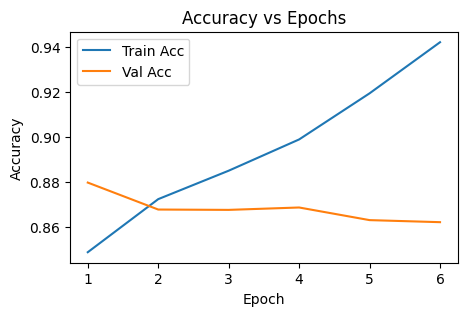

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_resnet50(resnet50_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 1 with val acc = 0.8798
Test Label-wise Accuracy: 54.8267 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.780 | AP: 0.403
Atelectasis          | AUC: 0.814 | AP: 0.740
Cardiomegaly         | AUC: 0.768 | AP: 0.629
Consolidation        | AUC: 0.882 | AP: 0.906
Edema                | AUC: 0.884 | AP: 0.721
Pleural Effusion     | AUC: 0.863 | AP: 0.750
Pneumonia            | AUC: 0.867 | AP: 0.180
Pneumothorax         | AUC: 0.762 | AP: 0.076

------ Summary ------ 
Mean AUC: 0.827
Mean AP:  0.551
Macro F1: 0.430
Micro F1: 0.511


We reproduce a ResNet-50 baseline on CheXpert using masked BCE loss and report AUC = 0.825

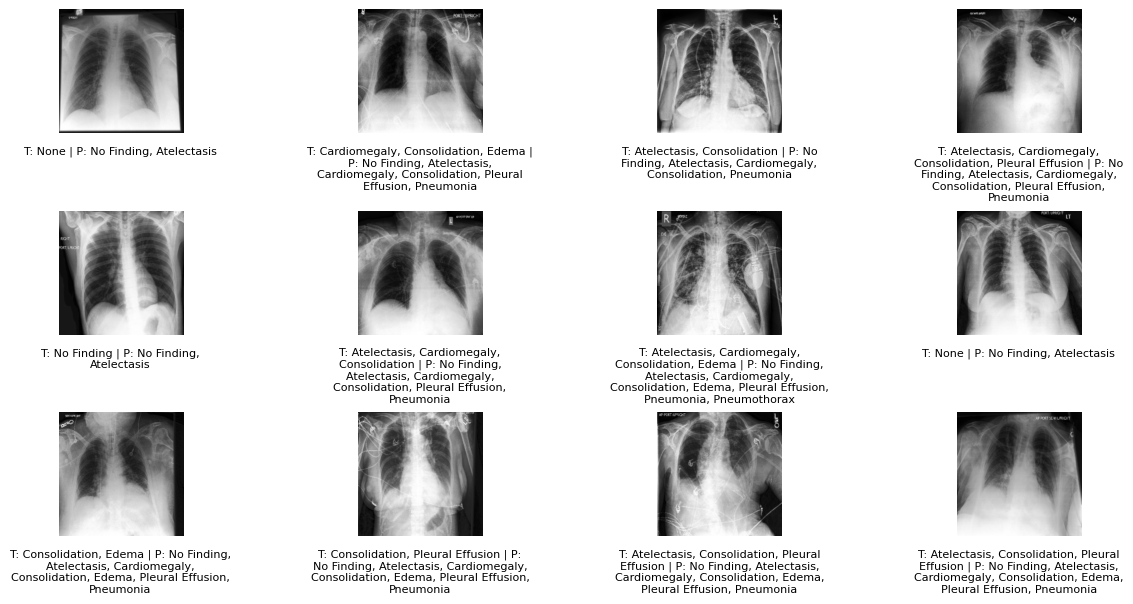

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model= test_acc_ckpt_resnet50(resnet50_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=6)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")

Loaded model from epoch 6
Test Label-wise Accuracy: 53.7748 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.701 | AP: 0.341
Atelectasis          | AUC: 0.754 | AP: 0.645
Cardiomegaly         | AUC: 0.769 | AP: 0.603
Consolidation        | AUC: 0.850 | AP: 0.880
Edema                | AUC: 0.888 | AP: 0.685
Pleural Effusion     | AUC: 0.854 | AP: 0.719
Pneumonia            | AUC: 0.802 | AP: 0.129
Pneumothorax         | AUC: 0.656 | AP: 0.077

------ Summary ------ 
Mean AUC: 0.784
Mean AP:  0.510
Macro F1: 0.442
Micro F1: 0.504


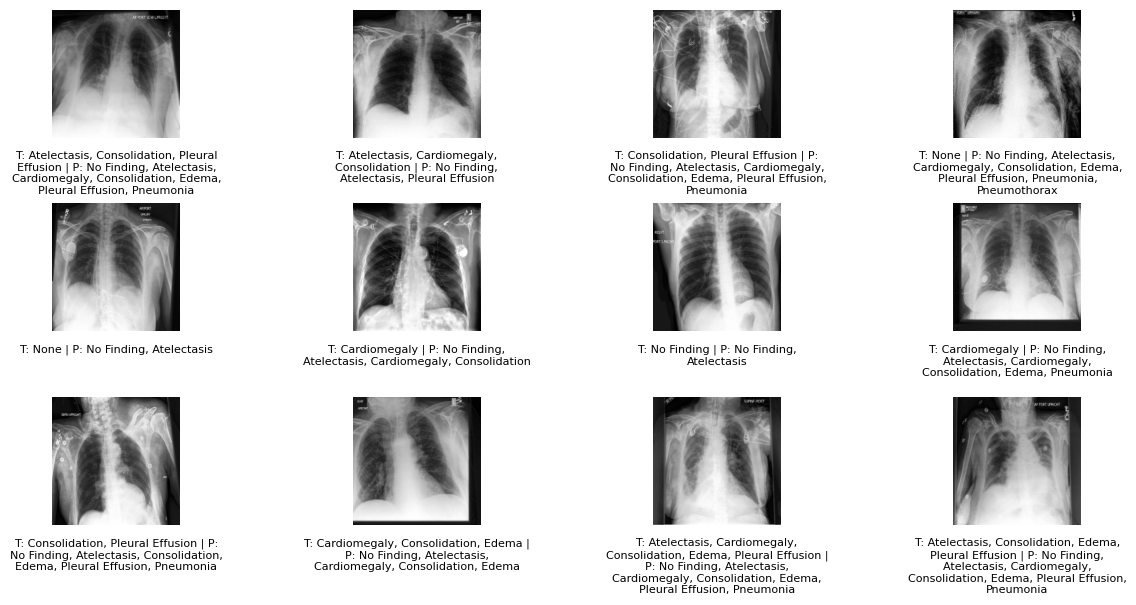

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### DenseNet121

In [35]:
def test_acc_best_model_densenet121(CHECKPOINT_DIR, num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_densenet121(num_classes,False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")

  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc , best_model

In [ ]:
def test_acc_ckpt_densenet121(CHECKPOINT_DIR, num_classes, test_loader, ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_densenet121(num_classes,False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in chexpert_test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds == labels)*masks).sum()
          total_test_labels  += masks.sum()

  test_acc = test_corrects.double() /  total_test_labels

  return test_acc, model

In [ ]:
densenet121_CHECKPOINT_DIR = os.path.join(EE782, f'densenet121_checkpoints_seed_{SEED}')
os.makedirs(densenet121_CHECKPOINT_DIR, exist_ok=True)

In [ ]:
densenet121_model = build_densenet121(num_classes)
densenet121_model = densenet121_model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 176MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(densenet121_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(densenet121_CHECKPOINT_DIR, densenet121_model, train_loader, val_loader,criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 508/508 [02:53<00:00,  2.93it/s]


Train Loss: 0.3544 | Train Accuracy: 0.8446



Val Epoch 1: 100%|██████████| 90/90 [00:14<00:00,  6.32it/s]


Validation Loss: 0.2998 | Validation Accuracy: 0.8729

New best model saved at epoch 1 with val accuracy = 0.8729

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 508/508 [02:52<00:00,  2.94it/s]


Train Loss: 0.3009 | Train Accuracy: 0.8708



Val Epoch 2: 100%|██████████| 90/90 [00:14<00:00,  6.24it/s]


Validation Loss: 0.2917 | Validation Accuracy: 0.8730

New best model saved at epoch 2 with val accuracy = 0.8730

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 508/508 [02:53<00:00,  2.93it/s]


Train Loss: 0.2779 | Train Accuracy: 0.8830



Val Epoch 3: 100%|██████████| 90/90 [00:14<00:00,  6.40it/s]


Validation Loss: 0.2979 | Validation Accuracy: 0.8727

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 508/508 [02:52<00:00,  2.94it/s]


Train Loss: 0.2491 | Train Accuracy: 0.8961



Val Epoch 4: 100%|██████████| 90/90 [00:14<00:00,  6.21it/s]


Validation Loss: 0.2940 | Validation Accuracy: 0.8759

New best model saved at epoch 4 with val accuracy = 0.8759

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 508/508 [02:52<00:00,  2.94it/s]


Train Loss: 0.2140 | Train Accuracy: 0.9141



Val Epoch 5: 100%|██████████| 90/90 [00:14<00:00,  6.24it/s]


Validation Loss: 0.3091 | Validation Accuracy: 0.8701

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 508/508 [02:53<00:00,  2.93it/s]


Train Loss: 0.1763 | Train Accuracy: 0.9302



Val Epoch 6: 100%|██████████| 90/90 [00:14<00:00,  6.15it/s]


Validation Loss: 0.3416 | Validation Accuracy: 0.8700

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 508/508 [02:53<00:00,  2.94it/s]


Train Loss: 0.1328 | Train Accuracy: 0.9495



Val Epoch 7: 100%|██████████| 90/90 [00:14<00:00,  6.18it/s]


Validation Loss: 0.3581 | Validation Accuracy: 0.8665

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 508/508 [02:52<00:00,  2.94it/s]


Train Loss: 0.0991 | Train Accuracy: 0.9638



Val Epoch 8: 100%|██████████| 90/90 [00:14<00:00,  6.20it/s]


Validation Loss: 0.4122 | Validation Accuracy: 0.8560

----------------- Epoch 9 -----------------


Train Epoch 9: 100%|██████████| 508/508 [02:51<00:00,  2.95it/s]


Train Loss: 0.0719 | Train Accuracy: 0.9753



Val Epoch 9: 100%|██████████| 90/90 [00:14<00:00,  6.38it/s]


Validation Loss: 0.4350 | Validation Accuracy: 0.8552


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8759 at epoch 4


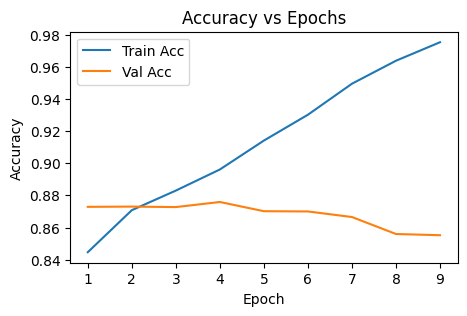

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_densenet121(densenet121_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 4 with val acc = 0.8759
Test Label-wise Accuracy: 56.6213 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.773 | AP: 0.421
Atelectasis          | AUC: 0.828 | AP: 0.711
Cardiomegaly         | AUC: 0.800 | AP: 0.651
Consolidation        | AUC: 0.879 | AP: 0.892
Edema                | AUC: 0.886 | AP: 0.680
Pleural Effusion     | AUC: 0.889 | AP: 0.760
Pneumonia            | AUC: 0.863 | AP: 0.223
Pneumothorax         | AUC: 0.741 | AP: 0.096

------ Summary ------ 
Mean AUC: 0.833
Mean AP:  0.554
Macro F1: 0.469
Micro F1: 0.522


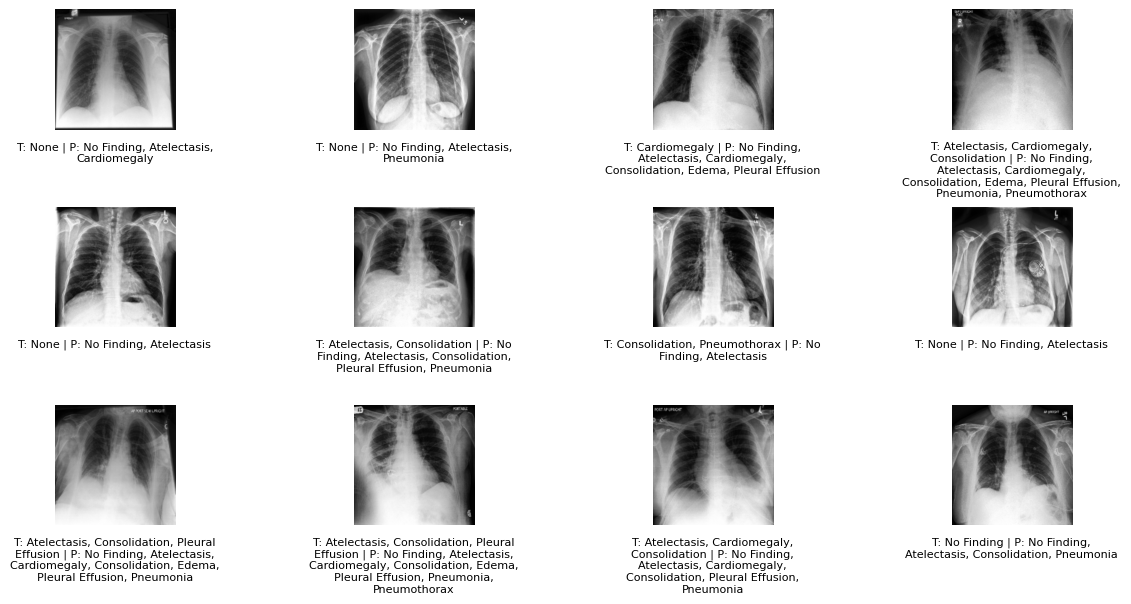

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model = test_acc_ckpt_densenet121(densenet121_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=9)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")

Loaded model from epoch 9
Test Label-wise Accuracy: 54.3936 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.812 | AP: 0.420
Atelectasis          | AUC: 0.738 | AP: 0.559
Cardiomegaly         | AUC: 0.784 | AP: 0.622
Consolidation        | AUC: 0.787 | AP: 0.825
Edema                | AUC: 0.886 | AP: 0.697
Pleural Effusion     | AUC: 0.867 | AP: 0.738
Pneumonia            | AUC: 0.775 | AP: 0.107
Pneumothorax         | AUC: 0.698 | AP: 0.152

------ Summary ------ 
Mean AUC: 0.794
Mean AP:  0.515
Macro F1: 0.448
Micro F1: 0.510


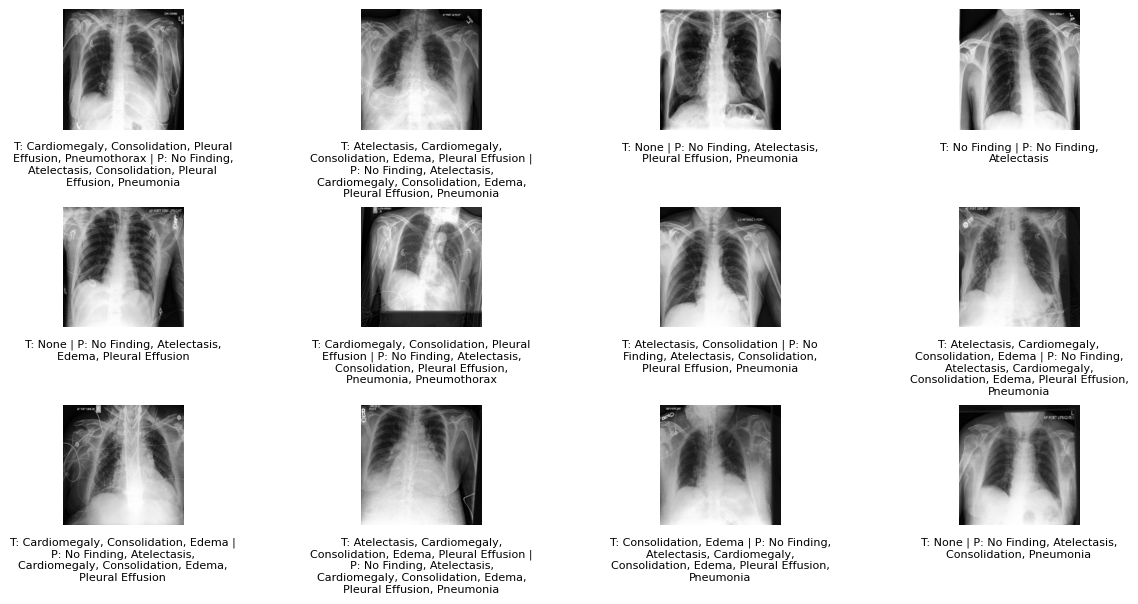

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### Vision Transformer(ViT_b_16)

In [36]:
def test_acc_best_model_vit(CHECKPOINT_DIR, num_classes,test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_vit_b_16(num_classes,False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")
  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, best_model

In [ ]:
def test_acc_ckpt_vit(CHECKPOINT_DIR,num_classes,test_loader,ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_vit_b_16(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels

  return test_acc, model

In [ ]:
vit_CHECKPOINT_DIR = os.path.join(EE782, 'vit_b_16_checkpoints')
os.makedirs(vit_CHECKPOINT_DIR, exist_ok = True)

In [ ]:
vit_b_16_model    = build_vit_b_16(num_classes)
vit_b_16_model    = vit_b_16_model.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 177MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(vit_b_16_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(vit_CHECKPOINT_DIR, vit_b_16_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 508/508 [09:02<00:00,  1.07s/it]


Train Loss: 0.4082 | Train Accuracy: 0.8196



Val Epoch 1: 100%|██████████| 90/90 [00:30<00:00,  2.97it/s]


Validation Loss: 0.3652 | Validation Accuracy: 0.8292

New best model saved at epoch 1 with val accuracy = 0.8292

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 508/508 [09:11<00:00,  1.09s/it]


Train Loss: 0.3612 | Train Accuracy: 0.8401



Val Epoch 2: 100%|██████████| 90/90 [00:30<00:00,  2.97it/s]


Validation Loss: 0.3430 | Validation Accuracy: 0.8566

New best model saved at epoch 2 with val accuracy = 0.8566

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 508/508 [09:10<00:00,  1.08s/it]


Train Loss: 0.3365 | Train Accuracy: 0.8521



Val Epoch 3: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]


Validation Loss: 0.3479 | Validation Accuracy: 0.8547

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 508/508 [09:07<00:00,  1.08s/it]


Train Loss: 0.3240 | Train Accuracy: 0.8581



Val Epoch 4: 100%|██████████| 90/90 [00:30<00:00,  2.98it/s]


Validation Loss: 0.3220 | Validation Accuracy: 0.8605

New best model saved at epoch 4 with val accuracy = 0.8605

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 508/508 [09:07<00:00,  1.08s/it]


Train Loss: 0.3050 | Train Accuracy: 0.8672



Val Epoch 5: 100%|██████████| 90/90 [00:30<00:00,  2.98it/s]


Validation Loss: 0.3535 | Validation Accuracy: 0.8547

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 508/508 [09:07<00:00,  1.08s/it]


Train Loss: 0.2878 | Train Accuracy: 0.8743



Val Epoch 6: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]


Validation Loss: 0.3276 | Validation Accuracy: 0.8582

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 508/508 [09:08<00:00,  1.08s/it]


Train Loss: 0.2615 | Train Accuracy: 0.8883



Val Epoch 7: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]


Validation Loss: 0.3395 | Validation Accuracy: 0.8600

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 508/508 [09:07<00:00,  1.08s/it]


Train Loss: 0.2390 | Train Accuracy: 0.8995



Val Epoch 8: 100%|██████████| 90/90 [00:30<00:00,  3.00it/s]


Validation Loss: 0.3392 | Validation Accuracy: 0.8558

----------------- Epoch 9 -----------------


Train Epoch 9: 100%|██████████| 508/508 [09:08<00:00,  1.08s/it]


Train Loss: 0.1990 | Train Accuracy: 0.9181



Val Epoch 9: 100%|██████████| 90/90 [00:30<00:00,  2.98it/s]


Validation Loss: 0.4043 | Validation Accuracy: 0.8442


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8605 at epoch 4


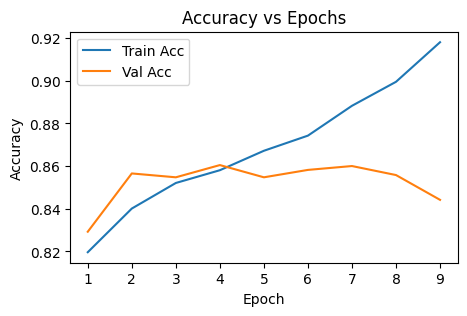

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_vit(vit_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 4 with val acc = 0.8605
Test Label-wise Accuracy: 52.7847 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.833 | AP: 0.384
Atelectasis          | AUC: 0.787 | AP: 0.634
Cardiomegaly         | AUC: 0.744 | AP: 0.577
Consolidation        | AUC: 0.842 | AP: 0.870
Edema                | AUC: 0.815 | AP: 0.582
Pleural Effusion     | AUC: 0.837 | AP: 0.744
Pneumonia            | AUC: 0.858 | AP: 0.333
Pneumothorax         | AUC: 0.633 | AP: 0.122

------ Summary ------ 
Mean AUC: 0.794
Mean AP:  0.531
Macro F1: 0.434
Micro F1: 0.486


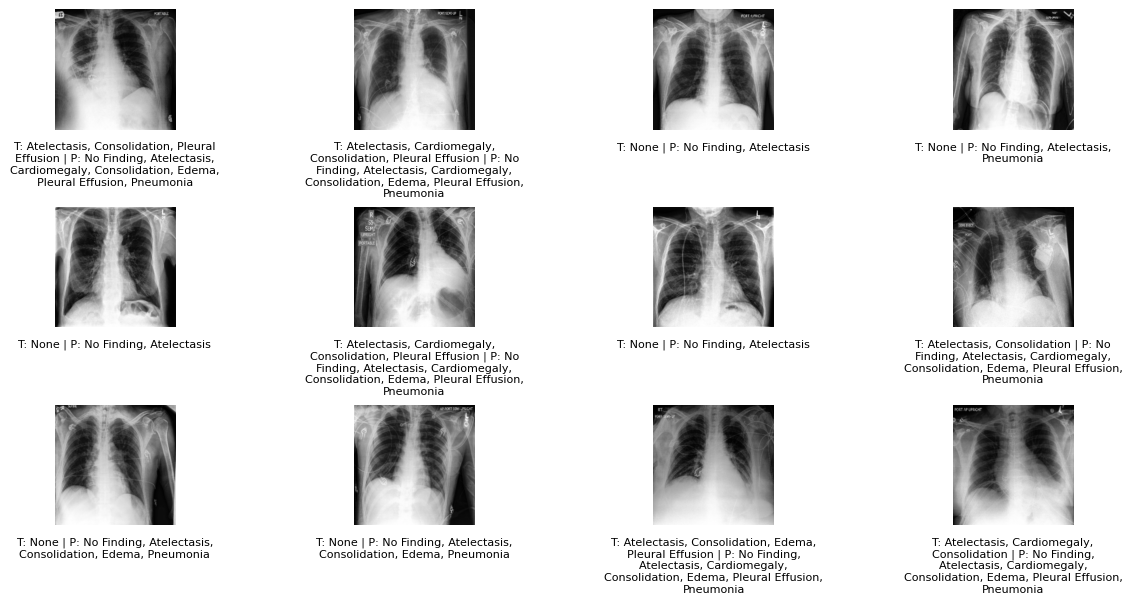

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model= test_acc_ckpt_vit(vit_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=9)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")

Loaded model from epoch 9
Test Label-wise Accuracy: 59.9629 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.592 | AP: 0.146
Atelectasis          | AUC: 0.767 | AP: 0.598
Cardiomegaly         | AUC: 0.769 | AP: 0.614
Consolidation        | AUC: 0.831 | AP: 0.867
Edema                | AUC: 0.780 | AP: 0.492
Pleural Effusion     | AUC: 0.871 | AP: 0.798
Pneumonia            | AUC: 0.812 | AP: 0.139
Pneumothorax         | AUC: 0.533 | AP: 0.053

------ Summary ------ 
Mean AUC: 0.744
Mean AP:  0.464
Macro F1: 0.447
Micro F1: 0.525


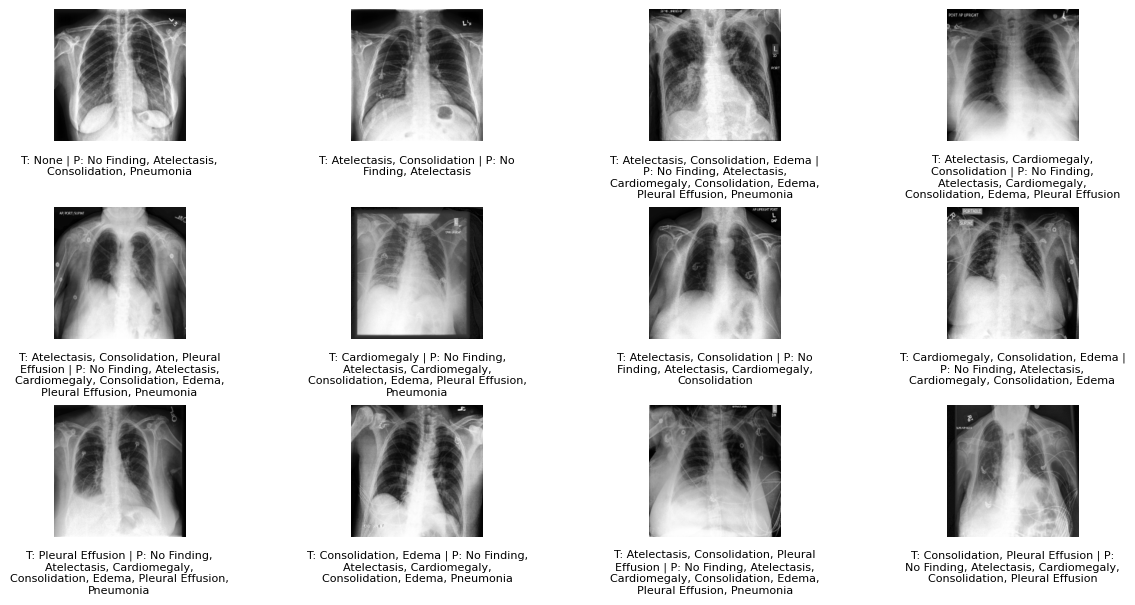

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### ConvNeXt-Tiny

In [37]:
def test_acc_best_model_convnext(CHECKPOINT_DIR ,num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_convnext(num_classes, False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()

  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")
  # Testing
  test_corrects = 0
  total_test_labels=0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, best_model

In [ ]:
def test_acc_ckpt_convnext(CHECKPOINT_DIR, num_classes, test_loader, ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_convnext(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, model

In [ ]:
convnext_CHECKPOINT_DIR = os.path.join(EE782, "convnext_checkpoints")
os.makedirs(convnext_CHECKPOINT_DIR, exist_ok = True)

In [ ]:
convnext_model    = build_convnext(num_classes)
convnext_model    = convnext_model.to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:01<00:00, 99.6MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(convnext_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(convnext_CHECKPOINT_DIR, convnext_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 508/508 [06:44<00:00,  1.25it/s]


Train Loss: 0.3441 | Train Accuracy: 0.8491



Val Epoch 1: 100%|██████████| 90/90 [00:17<00:00,  5.06it/s]


Validation Loss: 0.2995 | Validation Accuracy: 0.8760

New best model saved at epoch 1 with val accuracy = 0.8760

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 508/508 [06:34<00:00,  1.29it/s]


Train Loss: 0.2937 | Train Accuracy: 0.8755



Val Epoch 2: 100%|██████████| 90/90 [00:13<00:00,  6.50it/s]


Validation Loss: 0.2958 | Validation Accuracy: 0.8778

New best model saved at epoch 2 with val accuracy = 0.8778

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 508/508 [06:36<00:00,  1.28it/s]


Train Loss: 0.2629 | Train Accuracy: 0.8898



Val Epoch 3: 100%|██████████| 90/90 [00:13<00:00,  6.68it/s]


Validation Loss: 0.3072 | Validation Accuracy: 0.8739

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 508/508 [06:36<00:00,  1.28it/s]


Train Loss: 0.2192 | Train Accuracy: 0.9106



Val Epoch 4: 100%|██████████| 90/90 [00:13<00:00,  6.65it/s]


Validation Loss: 0.3472 | Validation Accuracy: 0.8572

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 508/508 [06:34<00:00,  1.29it/s]


Train Loss: 0.1590 | Train Accuracy: 0.9383



Val Epoch 5: 100%|██████████| 90/90 [00:13<00:00,  6.68it/s]


Validation Loss: 0.3576 | Validation Accuracy: 0.8724

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 508/508 [06:37<00:00,  1.28it/s]


Train Loss: 0.1029 | Train Accuracy: 0.9644



Val Epoch 6: 100%|██████████| 90/90 [00:13<00:00,  6.62it/s]


Validation Loss: 0.3778 | Validation Accuracy: 0.8711

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 508/508 [06:33<00:00,  1.29it/s]


Train Loss: 0.0700 | Train Accuracy: 0.9762



Val Epoch 7: 100%|██████████| 90/90 [00:13<00:00,  6.75it/s]


Validation Loss: 0.4207 | Validation Accuracy: 0.8649


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8778 at epoch 2


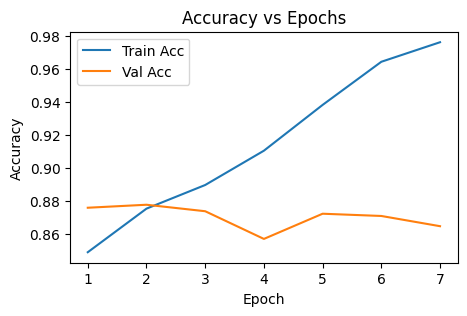

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_convnext(convnext_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 2 with val acc = 0.8778
Test Label-wise Accuracy: 53.8985 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.897 | AP: 0.514
Atelectasis          | AUC: 0.802 | AP: 0.645
Cardiomegaly         | AUC: 0.851 | AP: 0.749
Consolidation        | AUC: 0.878 | AP: 0.893
Edema                | AUC: 0.920 | AP: 0.781
Pleural Effusion     | AUC: 0.889 | AP: 0.779
Pneumonia            | AUC: 0.832 | AP: 0.200
Pneumothorax         | AUC: 0.639 | AP: 0.123

------ Summary ------ 
Mean AUC: 0.839
Mean AP:  0.585
Macro F1: 0.450
Micro F1: 0.511


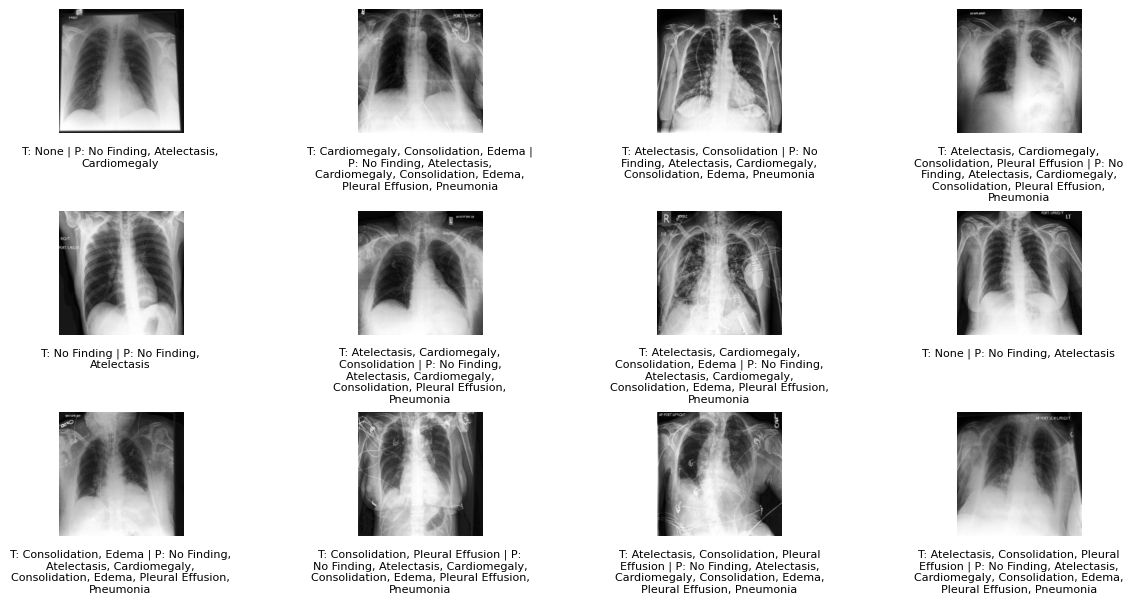

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model = test_acc_ckpt_convnext(convnext_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=7)
print(f"Test Accuracy: {t2*100:.4f} %")


Loaded model from epoch 7
Test Accuracy: 55.9406 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.749 | AP: 0.235
Atelectasis          | AUC: 0.786 | AP: 0.640
Cardiomegaly         | AUC: 0.812 | AP: 0.684
Consolidation        | AUC: 0.866 | AP: 0.877
Edema                | AUC: 0.899 | AP: 0.727
Pleural Effusion     | AUC: 0.883 | AP: 0.758
Pneumonia            | AUC: 0.807 | AP: 0.169
Pneumothorax         | AUC: 0.660 | AP: 0.222

------ Summary ------ 
Mean AUC: 0.808
Mean AP:  0.539
Macro F1: 0.462
Micro F1: 0.513


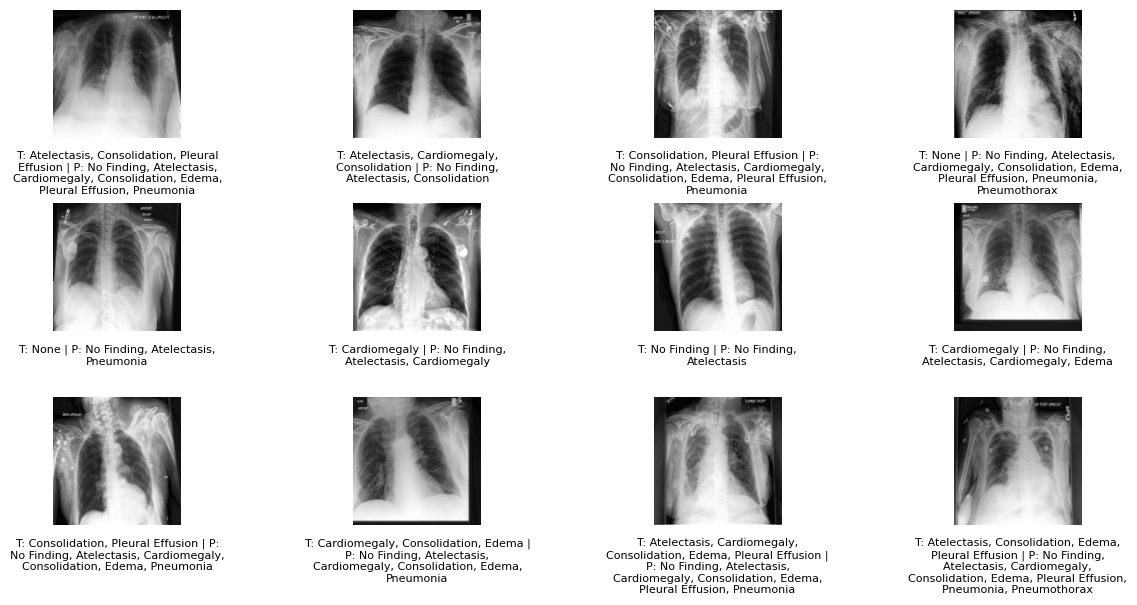

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

### Testing on other dataset(NIH ChestX-ray14)

#### NIH Chest X-Rays

##### Data

In [22]:
NIH_DATA    = os.path.join(EE782, 'NIH_DATA')
NIH_CSV     = os.path.join(EE782, 'NIH_DATA/Data_Entry_2017.csv')
NIH_IMG_DIR = os.path.join(EE782, 'NIH_DATA/images_001/images')

In [ ]:
files = os.listdir(NIH_IMG_DIR)
len(files)

4999

In [ ]:
nih_df = pd.read_csv(NIH_CSV)
nih_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [ ]:
len(nih_df)

112120

* Considering only the images in the "images_001" folder for testing

In [ ]:
img_dir_files   = set(os.listdir(NIH_IMG_DIR))

In [ ]:
filtered_nih_df = nih_df[nih_df["Image Index"].isin(img_dir_files)].copy()

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [ ]:
len(filtered_nih_df)

4999

In [ ]:
# updating the "Image Index" column with image path
PATH_COL = "Image Index"
filtered_nih_df[PATH_COL] = filtered_nih_df[PATH_COL].apply(lambda fn: os.path.join(NIH_IMG_DIR, fn))

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...            Cardiomegaly   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...  Cardiomegaly|Emphysema   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...   Cardiomegaly|Effusion   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...              No Finding   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...                  Hernia   

   Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
0            0           1           58              M            PA   
1            1           1           58              M            PA   
2            2           1           58              M            PA   
3            0           2           81              M            PA   
4            0           3           81              F            PA   

   OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
0                 2682     2749                        0.143  0.143   
1                 2894     2729                        0.143  0.143   
2                 2500     2048                        0.168  0.168   
3                 2500     2048                        0.171  0.171   
4                 2582     2991                        0.143  0.143   

   Unnamed: 11  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [ ]:
# NIH stores labels in a single string column "Finding Labels" (common), expanding them:
if "Finding Labels" in filtered_nih_df.columns and not any(c in filtered_nih_df.columns for c in nih_to_canon.keys()):

    # create one-hot columns from "Finding Labels" (strings like "Cardiomegaly|Effusion")
    filtered_nih_df["Finding Labels"] = filtered_nih_df["Finding Labels"].fillna("")
    for src in nih_to_canon.keys():
        filtered_nih_df[src] = filtered_nih_df["Finding Labels"].apply(lambda s: 1.0 if src in s.split("|") else 0.0)

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...            Cardiomegaly   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...  Cardiomegaly|Emphysema   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...   Cardiomegaly|Effusion   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...              No Finding   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...                  Hernia   

   Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
0            0           1           58              M            PA   
1            1           1           58              M            PA   
2            2           1           58              M            PA   
3            0           2           81              M            PA   
4            0           3           81              F            PA   

   OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
0                 2682     2749                        0.143  0.143   
1                 2894     2729                        0.143  0.143   
2                 2500     2048                        0.168  0.168   
3                 2500     2048                        0.171  0.171   
4                 2582     2991                        0.143  0.143   

   Unnamed: 11  No Finding  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0          NaN         0.0          0.0           1.0            0.0    0.0   
1          NaN         0.0          0.0           1.0            0.0    0.0   
2          NaN         0.0          0.0           1.0            0.0    0.0   
3          NaN         1.0          0.0           0.0            0.0    0.0   
4          NaN         0.0          0.0           0.0            0.0    0.0   

   Effusion  Pneumonia  Pneumothorax  
0       0.0        0.0           0.0  
1       0.0        0.0           0.0  
2       1.0        0.0           0.0  
3       0.0        0.0           0.0  
4       0.0        0.0           0.0

In [ ]:
# making NIH canonical dataframe
nih_canon_df = make_canonical_df(filtered_nih_df, nih_to_canon, canonical, path_col=PATH_COL)
nih_canon_df.head()

Path  No Finding  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         1.0   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 1           1.0   
1                1          0.0                 1           1.0   
2                1          0.0                 1           1.0   
3                1          0.0                 1           0.0   
4                1          0.0                 1           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  1            0.0                   1    0.0           1   
1                  1            0.0                   1    0.0           1   
2                  1            0.0                   1    0.0           1   
3                  1            0.0                   1    0.0           1   
4                  1            0.0                   1    0.0           1   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      1        0.0               1   
1               0.0                      1        0.0               1   
2               1.0                      1        0.0               1   
3               0.0                      1        0.0               1   
4               0.0                      1        0.0               1   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  1  
2           0.0                  1  
3           0.0                  1  
4           0.0                  1

In [ ]:
nih_canon_df.to_excel(os.path.join(NIH_DATA,'nih_canon_df.xlsx'), index=False)
print("DataFrame saved as 'nih_canon_df.xlsx'")

DataFrame saved as 'nih_canon_df.xlsx'


In [ ]:
# label prevalence
for c in canonical:
    valid = nih_canon_df[c + "_mask"].sum()
    positives = nih_canon_df[c].sum()
    print(f"{c:20s} | labeled: {int(valid):6d} | positives: {int(positives):6d} | prevalence: {positives/valid if valid>0 else np.nan:.3f}")

No Finding           | labeled:   4999 | positives:   2754 | prevalence: 0.551
Atelectasis          | labeled:   4999 | positives:    460 | prevalence: 0.092
Cardiomegaly         | labeled:   4999 | positives:    196 | prevalence: 0.039
Consolidation        | labeled:   4999 | positives:    205 | prevalence: 0.041
Edema                | labeled:   4999 | positives:     90 | prevalence: 0.018
Pleural Effusion     | labeled:   4999 | positives:    487 | prevalence: 0.097
Pneumonia            | labeled:   4999 | positives:     65 | prevalence: 0.013
Pneumothorax         | labeled:   4999 | positives:    199 | prevalence: 0.040


##### Custom Dataset Class

In [23]:
class NIH_Dataset(Dataset):
    def __init__(self, df, transform=None, target_cols=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_cols = target_cols
        self.mask_cols = [c + "_mask" for c in target_cols]
        self.classes = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["Path"]
        image = Image.open(img_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row[self.target_cols].to_numpy(dtype=np.float32))
        mask = torch.tensor(row[self.mask_cols].to_numpy(dtype=np.float32))
        return image, label, mask

##### DataLoader

In [24]:
nih_canon_df_pth = os.path.join(NIH_DATA,'nih_canon_df.xlsx')
nih_canon_df = pd.read_excel(nih_canon_df_pth)

In [25]:
len(nih_canon_df)

4999

In [26]:
nih_data_small = nih_canon_df.sample(frac=0.1, random_state=SEED).reset_index(drop=True)

In [27]:
len(nih_data_small)

500

In [28]:
nih_dataset      = NIH_Dataset(nih_data_small, transform=val_transforms, target_cols=canonical)
nih_test_loader  = DataLoader(nih_dataset, batch_size=32, shuffle=False,num_workers=2, pin_memory=True)

In [29]:
img, labels, mask = next(iter(nih_test_loader))
print(img.shape)
print(labels.shape)
print(mask.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 8])
torch.Size([32, 8])


#### Testing

In [30]:
num_classes = len(canonical)
num_classes

8

In [31]:
SEED=999

##### ResNet50

In [32]:
resnet50_CHECKPOINT_DIR = os.path.join(EE782, f'resnet50_checkpoints_seed_{SEED}')

In [38]:
t1, best_model = test_acc_best_model_resnet50(resnet50_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 1 with val acc = 0.8798
Test Label-wise Accuracy: 55.6000 %


In [39]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.692 | AP: 0.765
Atelectasis          | AUC: 0.688 | AP: 0.163
Cardiomegaly         | AUC: 0.767 | AP: 0.104
Consolidation        | AUC: 0.791 | AP: 0.159
Edema                | AUC: 0.891 | AP: 0.141
Pleural Effusion     | AUC: 0.857 | AP: 0.468
Pneumonia            | AUC: 0.706 | AP: 0.066
Pneumothorax         | AUC: 0.659 | AP: 0.078

------ Summary ------ 
Mean AUC: 0.757
Mean AP:  0.243
Macro F1: 0.214
Micro F1: 0.322


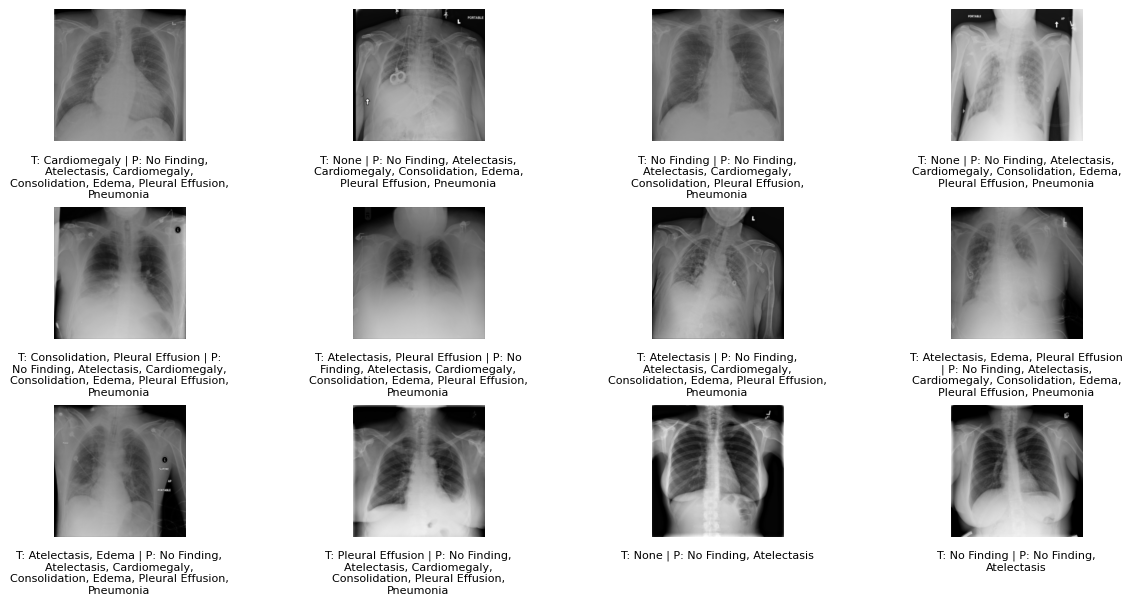

In [40]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### DenseNet121

In [41]:
densenet121_CHECKPOINT_DIR = os.path.join(EE782, f'densenet121_checkpoints_seed_{SEED}')

In [42]:
t1, best_model = test_acc_best_model_densenet121(densenet121_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 4 with val acc = 0.8759
Test Label-wise Accuracy: 62.9000 %


In [43]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.735 | AP: 0.777
Atelectasis          | AUC: 0.729 | AP: 0.188
Cardiomegaly         | AUC: 0.910 | AP: 0.217
Consolidation        | AUC: 0.817 | AP: 0.192
Edema                | AUC: 0.923 | AP: 0.165
Pleural Effusion     | AUC: 0.882 | AP: 0.472
Pneumonia            | AUC: 0.666 | AP: 0.041
Pneumothorax         | AUC: 0.773 | AP: 0.075

------ Summary ------ 
Mean AUC: 0.804
Mean AP:  0.266
Macro F1: 0.233
Micro F1: 0.360


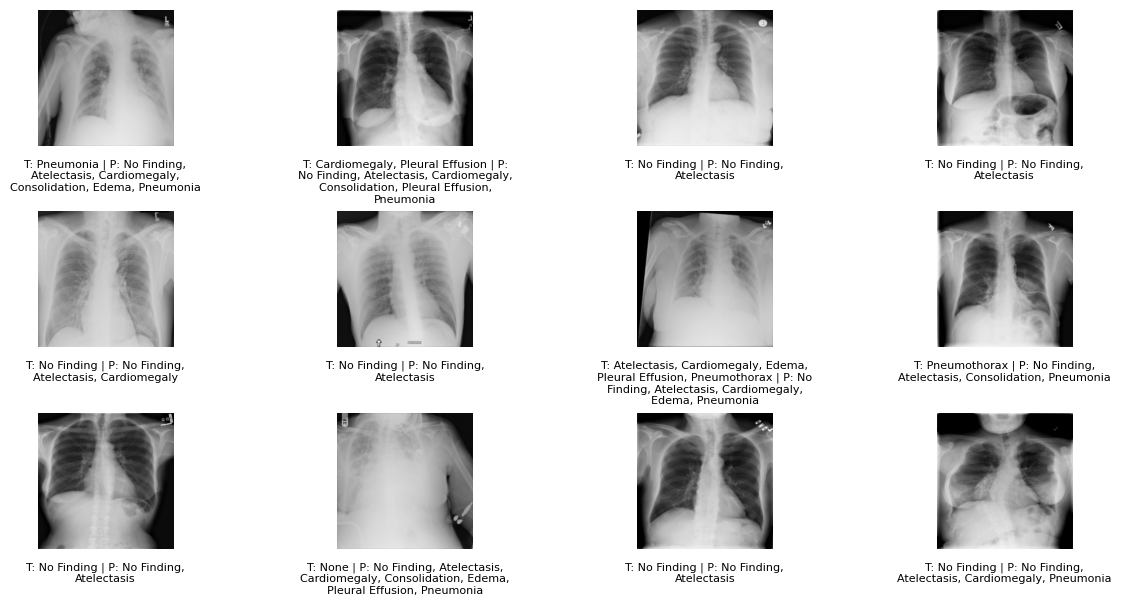

In [44]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### Vision Transformer(ViT_b_16)

In [45]:
vit_CHECKPOINT_DIR = os.path.join(EE782, f'vit_b_16_checkpoints_seed_{SEED}')

In [46]:
t1, best_model = test_acc_best_model_vit(vit_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 4 with val acc = 0.8605
Test Label-wise Accuracy: 56.3250 %


In [47]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.717 | AP: 0.706
Atelectasis          | AUC: 0.717 | AP: 0.210
Cardiomegaly         | AUC: 0.750 | AP: 0.061
Consolidation        | AUC: 0.760 | AP: 0.123
Edema                | AUC: 0.852 | AP: 0.087
Pleural Effusion     | AUC: 0.862 | AP: 0.379
Pneumonia            | AUC: 0.683 | AP: 0.045
Pneumothorax         | AUC: 0.674 | AP: 0.118

------ Summary ------ 
Mean AUC: 0.752
Mean AP:  0.216
Macro F1: 0.223
Micro F1: 0.326


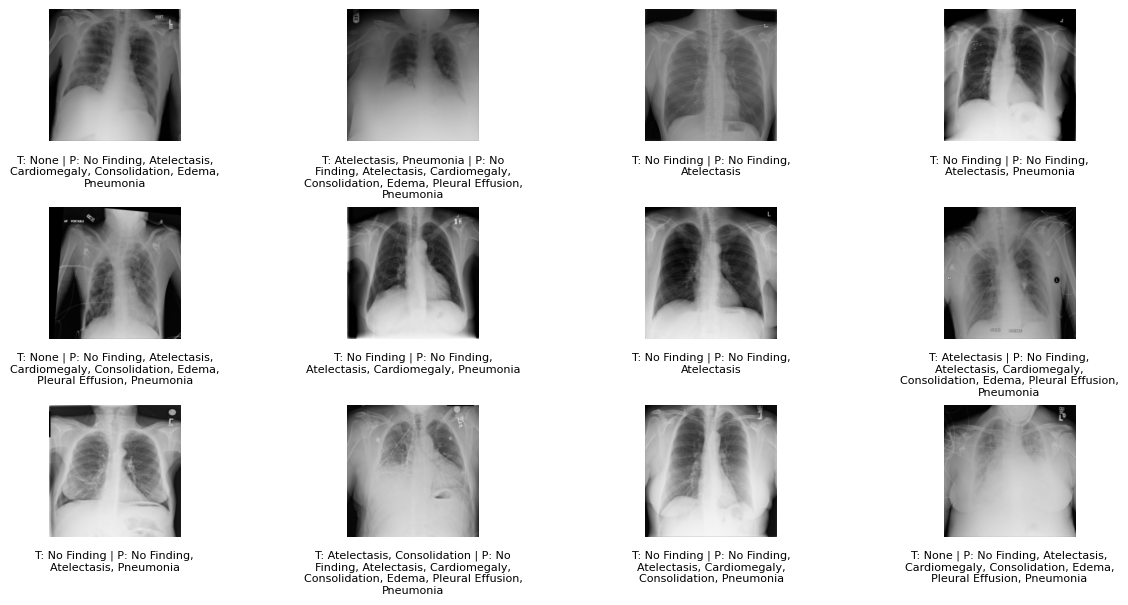

In [48]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### ConvNeXt-Tiny

In [49]:
convnext_CHECKPOINT_DIR = os.path.join(EE782, f"convnext_checkpoints_seed_{SEED}")

In [50]:
t1, best_model = test_acc_best_model_convnext(convnext_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 202MB/s]


Loaded best model from epoch 2 with val acc = 0.8778
Test Label-wise Accuracy: 54.9500 %


In [51]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.762 | AP: 0.725
Atelectasis          | AUC: 0.715 | AP: 0.172
Cardiomegaly         | AUC: 0.883 | AP: 0.256
Consolidation        | AUC: 0.774 | AP: 0.118
Edema                | AUC: 0.907 | AP: 0.113
Pleural Effusion     | AUC: 0.898 | AP: 0.577
Pneumonia            | AUC: 0.762 | AP: 0.058
Pneumothorax         | AUC: 0.672 | AP: 0.167

------ Summary ------ 
Mean AUC: 0.797
Mean AP:  0.273
Macro F1: 0.234
Micro F1: 0.323


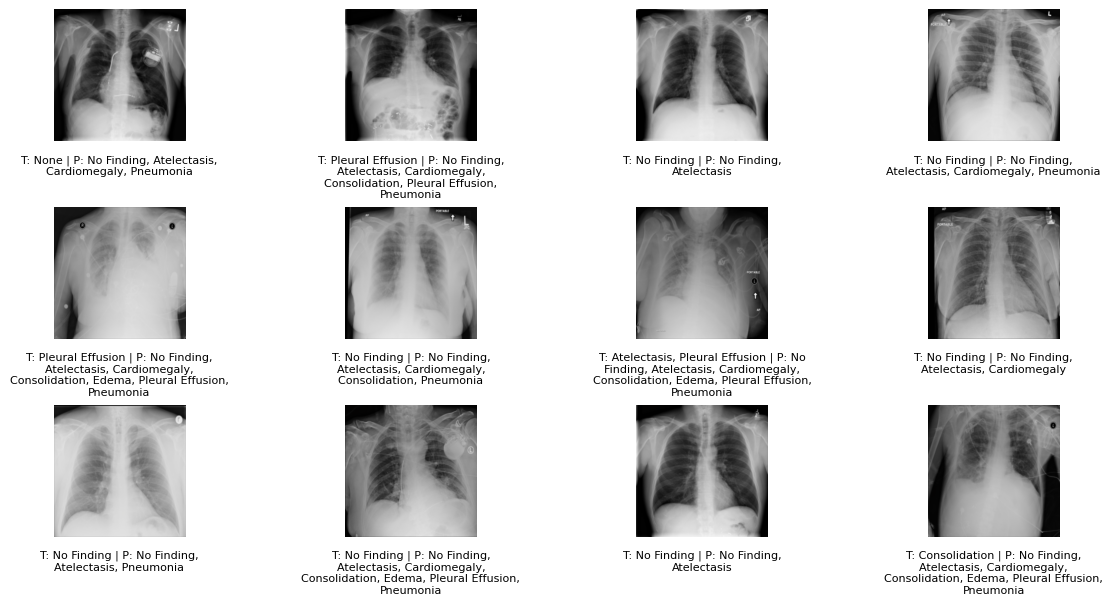

In [52]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)